In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Part 1 - Non-Linear Regression

Generate the data points

In [125]:
np.random.seed(42)

n = 25
degree = 9

x = np.random.rand(n)  
eps = np.random.uniform(-0.3, 0.3, n)

y = np.sin(5 * np.pi * x) + eps
X = np.column_stack([x**k for k in range(degree + 1)])

X_temp, X_test, y_temp, y_test, x_temp, x_test = train_test_split(
    X, y, x, test_size=5, random_state=2)

X_temp.shape, X_test.shape

((20, 10), (5, 10))

In [126]:
lambdas = [0, 0.01, 0.1, 1, 10]
cv_errors = {}

X_cv = X_temp
y_cv = y_temp
x_cv = x_temp

for lam in lambdas:
    errors = []

    for i in range(len(X_cv)):
        X_train = np.delete(X_cv, i, axis=0)
        y_train = np.delete(y_cv, i, axis=0)

        X_val = X_cv[i].reshape(1, -1)
        y_val = y_cv[i]

        model = Ridge(alpha=lam)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        errors.append((y_val - y_pred[0])**2)

    cv_errors[lam] = np.mean(errors)

cv_errors

{0: np.float64(7.676556651149092),
 0.01: np.float64(0.44309993330261205),
 0.1: np.float64(0.4274997550614595),
 1: np.float64(0.4179332481944069),
 10: np.float64(0.4209987245112986)}

In [127]:
best_lambda = min(cv_errors, key=cv_errors.get)
best_lambda

1

In [128]:
final_model = Ridge(alpha=best_lambda)
final_model.fit(X_cv, y_cv)

,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [129]:
y_pred_test = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mse

0.215123031992375

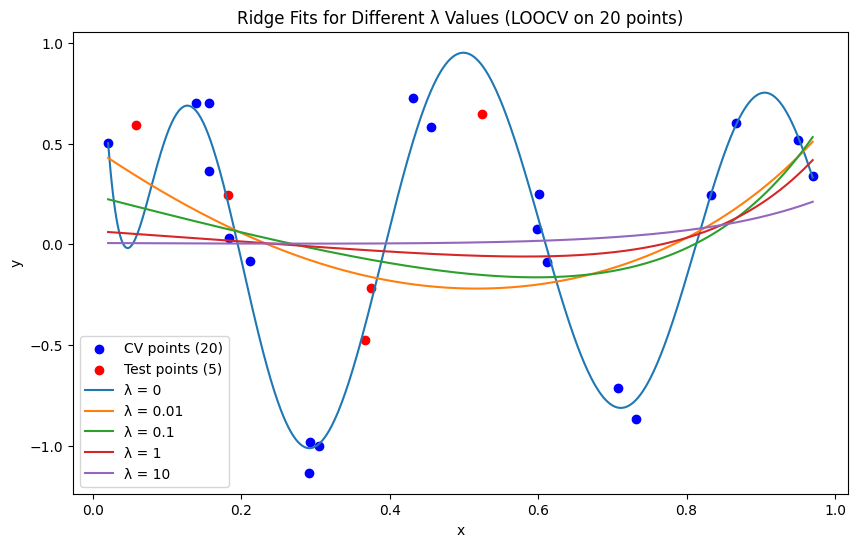

In [133]:
plt.figure(figsize=(10,6))

# plot train (20 points) and test (5 points)
plt.scatter(x_cv, y_cv, color='blue', label='CV points (20)')
plt.scatter(x_test, y_test, color='red', label='Test points (5)')

# grid for curves
grid = np.linspace(x.min(), x.max(), 600)
X_grid = np.column_stack([grid**k for k in range(degree + 1)])

# plot all λ curves
lambdas = [0, 0.01, 0.1, 1, 10]
# lambdas = [1]
for lam in lambdas:
    model = Ridge(alpha=lam)
    model.fit(X_cv, y_cv)
    y_pred_grid = model.predict(X_grid)
    plt.plot(grid, y_pred_grid, label=f"λ = {lam}")

plt.title("Ridge Fits for Different λ Values (LOOCV on 20 points)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [ ]:
print("LOOCV Errors:")
for lam, err in cv_errors.items():
    print(f"lambda = {lam:<5}   CV MSE = {err:.6f}")

print("\nBest lambda:", best_lambda)
print("Final Test MSE:", test_mse)

LOOCV Errors:
λ = 0       CV MSE = 7.676557
λ = 0.01    CV MSE = 0.443100
λ = 0.1     CV MSE = 0.427500
λ = 1       CV MSE = 0.417933
λ = 10      CV MSE = 0.420999

Best λ: 1
Final Test MSE: 0.215123031992375
